In [6]:
from __future__ import print_function

%matplotlib inline
import argparse
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  276


In [13]:
class Config:
    dataroot = "../input/celeba-dataset/img_align_celeba" # Root directory for dataset
    workers = 2 # Number of workers for dataloader
    batch_size = 128 # Batch size during training
    image_size = 64
    nc = 3 # Number of channels in the training images
    nz = 100 # Size of z latent vector (i.e. size of generator input)
    ngf = 64 # Size of feature maps in generator
    ndf = 64 # Size of feature maps in discriminator
    num_epochs = 15 # Number of training epochs
    lr = 0.0002 # Learning rate for optimizers
    beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
    ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

In [14]:
dataset = torchvision.datasets.ImageFolder(root=Config.dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(Config.image_size),
                               transforms.CenterCrop(Config.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

## Create a dataloader to load the data in batches :

In [16]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=Config.batch_size,
                                         shuffle=True, num_workers=Config.workers)

torch.Size([128, 3, 64, 64])


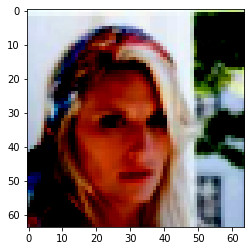

In [20]:
for images, labels in data_loader:
    print(images.shape)
    plt.imshow(images[0].permute(1, 2, 0))
    break

## Visualization :

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        plt.figure(figsize=(12, 6))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

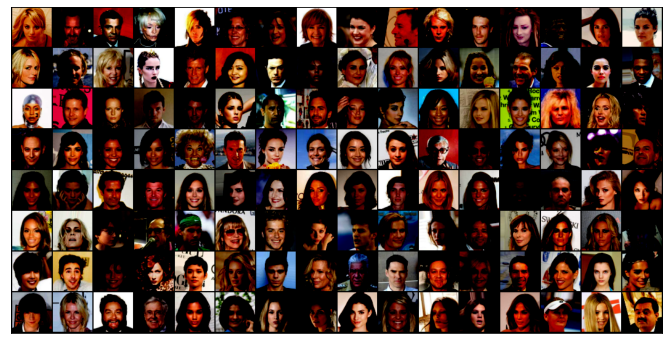

In [22]:
show_batch(data_loader)

## Helper functions :

In [25]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

# Modeling :
### Custom weights initialization called on Generator and Discriminator :

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator :

In [33]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.network = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(Config.nz, Config.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(Config.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(Config.ngf * 8, Config.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(Config.ngf * 4, Config.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(Config.ngf * 2, Config.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(Config.ngf, Config.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, xb):
        return self.network(xb)

## Discriminator :

In [38]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.network = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(Config.nc, Config.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(Config.ndf, Config.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(Config.ndf * 2, Config.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(Config.ndf * 4, Config.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(Config.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, xb):
        return self.network(xb)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
data_loader = DeviceDataLoader(data_loader, device)
# Create the generator
generator = Generator(Config.ngpu)
discriminator = Discriminator(Config.ngpu)

In [41]:
to_device(generator, device)
to_device(discriminator, device)

generator.apply(weights_init)
discriminator.apply(weights_init)

print(generator)
print(discriminator)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

In [51]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, Config.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
d_optimizer = optim.Adam(discriminator.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))

In [45]:
batch = next(iter(data_loader))

In [79]:
real_cpu = batch[0].to(device)
torch.full((real_cpu.size(0),), real_label, dtype=torch.float, device=device)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

In [111]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create labels which are later used as input for the BCE loss
    b_size = images.size(0)
    real_labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    fake_labels = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

    # loss for real images
    outputs = discriminator(images).view(-1)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # loss for fake images
    z = torch.randn(b_size, Config.nz, 1, 1, device=device)
    fake_images = generator(z)
    outputs = discriminator(fake_images).view(-1)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradient
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [108]:
for images, labels in data_loader:
    print(images.size(0))
    print(discriminator(images).size())
    break

128
torch.Size([128, 1, 1, 1])


In [112]:
def train_generator(images):
    # Generate fake images and compute loss
    b_size = images.size(0)
    z = torch.randn(b_size, Config.nz, 1, 1, device=device)
    fake_images = generator(z)
    labels = torch.full((b_size,), 1., dtype=torch.float, device=device)
    g_loss = criterion(discriminator(fake_images).view(-1), labels)

    # Backprop
    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

## Training loop :

In [113]:
def fit(num_epochs, data_loader):
    total_step = len(data_loader)
    d_losses, g_losses, real_scores, fake_scores = [], [], [], []
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            d_loss, real_score, fake_score = train_discriminator(images.to(device))
            g_loss, fake_images = train_generator(images.to(device))

            # View losses
            if (i+1) % 200 == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())

                print(f'Epoch {epoch}/{num_epochs}, Step {i+1}/{total_step}, d_loss:{d_loss.item()}, g_loss:{g_loss.item()}')

In [114]:
fit(Config.num_epochs, data_loader)

Epoch 0/15, Step 200/1583, d_loss:0.27156224846839905, g_loss:3.6400704383850098
Epoch 0/15, Step 400/1583, d_loss:0.5023996233940125, g_loss:4.538179397583008
Epoch 0/15, Step 600/1583, d_loss:1.8323376178741455, g_loss:3.210724353790283
Epoch 0/15, Step 800/1583, d_loss:0.6140519380569458, g_loss:4.063741683959961
Epoch 0/15, Step 1000/1583, d_loss:0.39270341396331787, g_loss:3.062540054321289
Epoch 0/15, Step 1200/1583, d_loss:0.4835045635700226, g_loss:1.8717787265777588
Epoch 0/15, Step 1400/1583, d_loss:0.48845386505126953, g_loss:1.983480453491211
Epoch 1/15, Step 200/1583, d_loss:0.3371928036212921, g_loss:3.3016090393066406
Epoch 1/15, Step 400/1583, d_loss:0.6664313077926636, g_loss:2.34234356880188
Epoch 1/15, Step 600/1583, d_loss:0.5472251176834106, g_loss:3.5445022583007812
Epoch 1/15, Step 800/1583, d_loss:0.4862978458404541, g_loss:1.6734768152236938
Epoch 1/15, Step 1000/1583, d_loss:0.4799189269542694, g_loss:2.7553935050964355
Epoch 1/15, Step 1200/1583, d_loss:0.546

In [49]:
rand = torch.randn(1, nz, 1, 1, device=device)
fake_img = netG(rand)
fake_img = fake_img.to("cpu").detach()
fake_img = fake_img.squeeze()

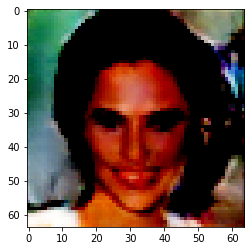

In [54]:
plt.imshow(fake_img.permute(1, 2, 0))

In [127]:
torch.save(generator.state_dict(), "generator.pth")